# Plotting connectivity 2d

Example of a MNE-based function which plots connectivity-like data in 2d

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [3]:
import mne

In [4]:
# no A1 and A2 here
channels_to_use = [
    't6',
    't4',
    'o1',
    'f8',
    'p4',
    'c4',
    't3',
    'f7',
    'f3',
    'o2',
    'f4',
    'c3',
    'p3',
    't5',
    'cz',
    'fp1',
    'fp2',
    'pz',
    'fz'
]

In [5]:
ten_twenty_montage = mne.channels.make_standard_montage('standard_1020')

# create Info object to store info
info = mne.io.meas_info.create_info(ten_twenty_montage.ch_names, sfreq=256, ch_types="eeg")
# using temporary RawArray to apply mongage to info
mne.io.RawArray(np.zeros((len(ten_twenty_montage.ch_names), 1)), info, copy=None).set_montage(ten_twenty_montage)

# pick channels
channels_to_use_ = [ch for ch in info.ch_names if ch.lower() in channels_to_use]
info.pick_channels(channels_to_use_);

Creating RawArray with float64 data, n_channels=94, n_times=1
    Range : 0 ... 0 =      0.000 ...     0.000 secs
Ready.


In [6]:
def plot_topomap_connectivity_2d(info, con, picks=None, pairs=None, vmin=None, vmax=None, cm=None, show_values=False):
    """
    Plots connectivity-like data in 2d
    
    Drawing every pair of channels will likely make a mess
    There are two options to avoid it:
    - provide picks
    - provide specific pairs of channels to draw
    """
    
    # get positions
    _, pos, _, _, _, _, _ = mne.viz.topomap._prepare_topomap_plot(info, 'eeg');
    
    ch_names_lower = [ch.lower() for ch in info.ch_names]
    if picks:
        picks_lower = [ch.lower() for ch in picks]
    if pairs:
        pairs_lower = [tuple(sorted([ch1.lower(), ch2.lower()])) for ch1, ch2 in pairs]
    
    rows = []
    for idx1, ch1 in enumerate(ch_names_lower):
        for idx2, ch2 in enumerate(ch_names_lower):
            if ch1 >= ch2:
                continue
            if picks and (ch1 not in picks_lower or ch2 not in picks_lower):
                    continue
            if pairs and (ch1, ch2) not in pairs_lower:
                    continue
            rows.append((
                pos[idx1],
                pos[idx2],
                con[idx1, idx2]
            ))
    if not len(rows):
        raise ValueError('No pairs to plot')
    
    con_to_plot = np.array([row[2] for row in rows])
    if vmin is None:
        vmin = np.percentile(con_to_plot, 2)
    if vmax is None:
        vmax = np.percentile(con_to_plot, 98)
    norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
    
    if cm is None:
        cm = sns.diverging_palette(240, 10, as_cmap=True)
    
    fig, ax = plt.subplots(figsize=[5, 5])
    mne.viz.utils.plot_sensors(info, show_names=True, show=False, axes=ax);
    for row in rows:
        rgba_color = cm(norm(row[2]))
        plt.plot([row[0][0], row[1][0]], [row[0][1], row[1][1]], color=rgba_color)
        if show_values:
            plt.text((row[0][0] + row[1][0]) / 2, 
                     (row[0][1] + row[1][1]) / 2, 
                     '{:.2f}'.format(row[2]))

## Lets test plotting on my data

Lets visualize a difference of connectivity of patients and hc groups for different ages and connetivity metrics (coherence and envelopes correlation)

In [7]:
path_df = pd.read_csv('../../preproc_data/autists/path_file.csv')

intervals = [
    ('All', 0, 100),
    ('2-4', 2, 4),
    ('5-6', 5, 6),
    ('7+', 7, 100),
    ('7-8', 7, 8),
    ('6-8', 6, 8),
    ('9+', 9, 100), 
]

rows = []
to_select = {}
for name, val_from, val_to in intervals:
    cur_df = path_df[(path_df['age'] >= val_from) & (path_df['age'] <= val_to)]
    to_select[name] = cur_df['fn']
    rows.append({
        'Age': name,
        'N': len(cur_df),
        'N autism': len(cur_df[cur_df['target'] == 'asd']),
        'N hc': len(cur_df[cur_df['target'] == 'typical']),
    })
    
age_summary_df = pd.DataFrame(rows)
age_summary_df

,Age,N,N autism,N hc
0,All,248,123,89
1,2-4,64,39,16
2,5-6,70,30,33
3,7+,114,54,40
4,7-8,53,32,14
5,6-8,81,41,30
6,9+,61,22,26


In [8]:
# helper function to get con matrix from my csv file with computed features
def get_con_matrix(con_dict, ch_names):
    ch_names = [ch.lower() for ch in ch_names]
    n_ch = len(ch_names)
    con = np.zeros((n_ch, n_ch))
    for k, v in con_dict.items():
        _, _, ch1, ch2 = k.split('_')
        try:
            ch1_idx = ch_names.index(ch1)
        except ValueError:
            continue
        try:         
            ch2_idx = ch_names.index(ch2)
        except ValueError:
            continue
        con[ch1_idx, ch2_idx] = v
        con[ch2_idx, ch1_idx] = v
    return con

In [9]:
df = pd.read_csv('../own_data/200426_autists_features_v2_thr30/full/coh_alpha.csv').dropna()

df = df[df['fn'].isin(to_select['2-4'])]

coh_cols = [col for col in df if 'coh' in col]

dict_diff = (
    df[df['target'] == 'asd'][coh_cols].mean() -
    df[df['target'] == 'typical'][coh_cols].mean()
).to_dict()

con_diff = get_con_matrix(dict_diff, info.ch_names)

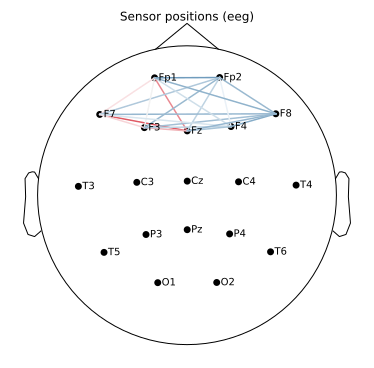

In [10]:
plot_topomap_connectivity_2d(info, con_diff, picks=['fp1', 'fp2', 'f7', 'f3', 'fz', 'f4', 'f8'], vmin=-0.1, vmax=0.1)

In [11]:
df = pd.read_csv('../own_data/200426_autists_features_v2_thr30/full/coh_alpha.csv').dropna()

df = df[df['fn'].isin(to_select['5-6'])]

coh_cols = [col for col in df if 'coh' in col]

dict_diff = (
    df[df['target'] == 'asd'][coh_cols].mean() -
    df[df['target'] == 'typical'][coh_cols].mean()
).to_dict()

con_diff = get_con_matrix(dict_diff, info.ch_names)

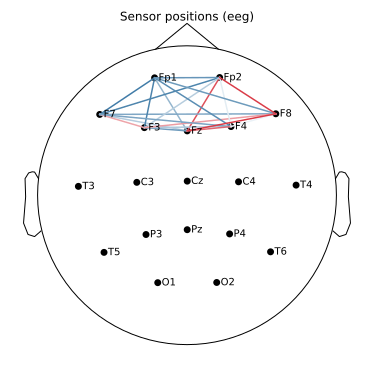

In [12]:
plot_topomap_connectivity_2d(info, con_diff, picks=['fp1', 'fp2', 'f7', 'f3', 'fz', 'f4', 'f8'])

In [13]:
df = pd.read_csv('../own_data/200426_autists_features_v2_thr30/full/env_alpha.csv').dropna()

df = df[df['fn'].isin(to_select['2-4'])]

env_cols = [col for col in df if 'env' in col]

dict_diff = (
    df[df['target'] == 'asd'][env_cols].mean() -
    df[df['target'] == 'typical'][env_cols].mean()
).to_dict()

con_diff = get_con_matrix(dict_diff, info.ch_names)

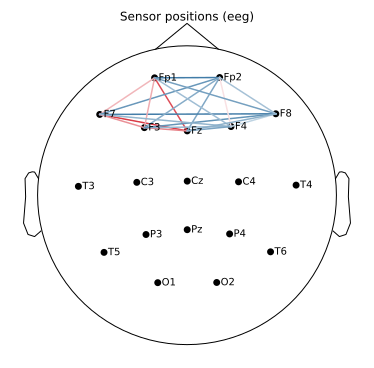

In [14]:
plot_topomap_connectivity_2d(info, con_diff, picks=['fp1', 'fp2', 'f7', 'f3', 'fz', 'f4', 'f8'])

In [15]:
df = pd.read_csv('../own_data/200426_autists_features_v2_thr30/full/env_alpha.csv').dropna()

df = df[df['fn'].isin(to_select['5-6'])]

env_cols = [col for col in df if 'env' in col]

dict_diff = (
    df[df['target'] == 'asd'][env_cols].mean() -
    df[df['target'] == 'typical'][env_cols].mean()
).to_dict()

con_diff = get_con_matrix(dict_diff, info.ch_names)

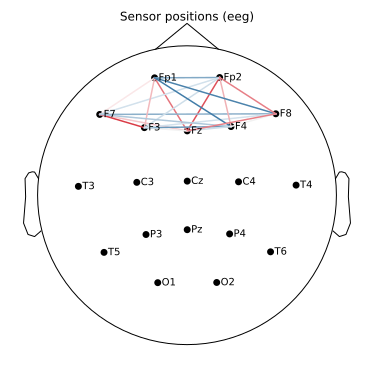

In [16]:
plot_topomap_connectivity_2d(info, con_diff, picks=['fp1', 'fp2', 'f7', 'f3', 'fz', 'f4', 'f8'])